In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [33]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])

###출력은 기본적으로 인코더의 입력과같다.
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer = keras.optimizers.SGD(lr=0.1))

In [34]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 3ms/sample - loss: 0.8063
Epoch 2/20
60/60 [==============================] - 0s 116us/sample - loss: 0.6137
Epoch 3/20
60/60 [==============================] - 0s 100us/sample - loss: 0.5093
Epoch 4/20
60/60 [==============================] - 0s 100us/sample - loss: 0.4426
Epoch 5/20
60/60 [==============================] - 0s 100us/sample - loss: 0.3938
Epoch 6/20
60/60 [==============================] - 0s 83us/sample - loss: 0.3555
Epoch 7/20
60/60 [==============================] - 0s 99us/sample - loss: 0.3234
Epoch 8/20
60/60 [==============================] - 0s 100us/sample - loss: 0.2950
Epoch 9/20
60/60 [==============================] - 0s 83us/sample - loss: 0.2680
Epoch 10/20
60/60 [==============================] - 0s 83us/sample - loss: 0.2416
Epoch 11/20
60/60 [==============================] - 0s 100us/sample - loss: 0.2157
Epoch 12/20
60/60 [==============================] - 0s 83us/sample - l

In [35]:
codings = encoder.predict(X_train)

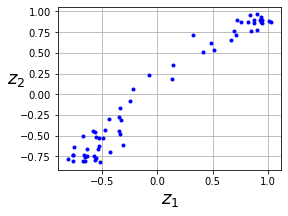

In [41]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [42]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# 적층 오토인코더 

In [107]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [108]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data = (X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.3382 - rounded_accuracy: 0.8869 - val_loss: 0.3120 - val_rounded_accuracy: 0.9094
Epoch 2/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3055 - rounded_accuracy: 0.9154 - val_loss: 0.3049 - val_rounded_accuracy: 0.9128
Epoch 3/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.2987 - rounded_accuracy: 0.9215 - val_loss: 0.2973 - val_rounded_accuracy: 0.9243
Epoch 4/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.2949 - rounded_accuracy: 0.9249 - val_loss: 0.2948 - val_rounded_accuracy: 0.9275
Epoch 5/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.2922 - rounded_accuracy: 0.9274 - val_loss: 0.2934 - val_rounded_accuracy: 0.9288
Epoch 6/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2903 - rounded_accuracy: 0.9291 - val_loss

In [72]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

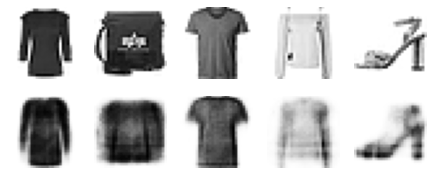

In [73]:
show_reconstructions(stacked_ae)

In [74]:
def show_reconstructions_train(model, images=X_train, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

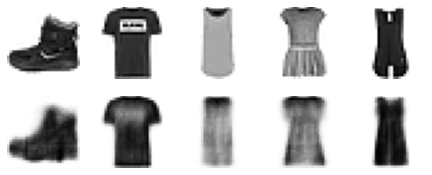

In [75]:
show_reconstructions_train(stacked_ae)

In [58]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

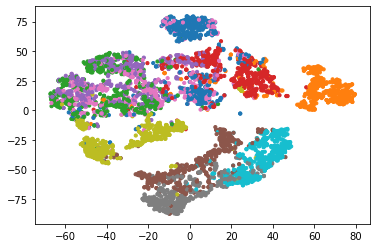

In [61]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")

# 비지도학습

In [109]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense=dense
        self.activation=keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros", shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
        print(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        return self.activation(z + self.biases)

In [110]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1, dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

(None, 30)
(None, 100)


In [111]:
tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3276 - rounded_accuracy: 0.8952 - val_loss: 0.3034 - val_rounded_accuracy: 0.9187
Epoch 2/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.2980 - rounded_accuracy: 0.9220 - val_loss: 0.2943 - val_rounded_accuracy: 0.9277
Epoch 3/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.2916 - rounded_accuracy: 0.9281 - val_loss: 0.2908 - val_rounded_accuracy: 0.9311
Epoch 4/10
55000/55000 [==============================] - 5s 90us/sample - loss: 0.2884 - rounded_accuracy: 0.9310 - val_loss: 0.2913 - val_rounded_accuracy: 0.9256
Epoch 5/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.2864 - rounded_accuracy: 0.9327 - val_loss: 0.2863 - val_rounded_accuracy: 0.9342
Epoch 6/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.2849 - rounded_accuracy: 0.9340 - val_loss:

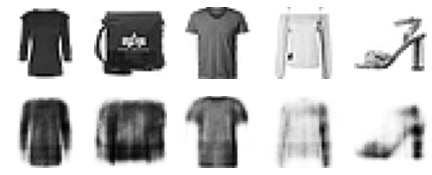

In [76]:
show_reconstructions(tied_ae)
plt.show()

In [81]:
X_train.shape[-1]

28

In [82]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [117]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid", metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 90us/sample - loss: 0.3444 - rounded_accuracy: 0.8875 - val_loss: 0.3114 - val_rounded_accuracy: 0.9159
Epoch 2/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3028 - rounded_accuracy: 0.9214 - val_loss: 0.2997 - val_rounded_accuracy: 0.9250
Epoch 3/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.2943 - rounded_accuracy: 0.9292 - val_loss: 0.2930 - val_rounded_accuracy: 0.9321
Epoch 4/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.2888 - rounded_accuracy: 0.9345 - val_loss: 0.2885 - val_rounded_accuracy: 0.9362
Epoch 5/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2851 - rounded_accuracy: 0.9381 - val_loss: 0.2855 - val_rounded_accuracy: 0.9393
Epoch 6/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.2824 - rounded_accuracy: 0.9406 - val_loss:

In [101]:
X_train_enc1

<tf.Tensor: shape=(55000, 100), dtype=float32, numpy=
array([[ 2.899841  , -0.07063891,  2.393328  , ...,  4.598262  ,
         4.015145  ,  4.6966    ],
       [-1.6050962 ,  2.7536752 ,  2.2458057 , ...,  2.8706055 ,
         0.28742263,  4.530088  ],
       [ 1.6825762 ,  4.117935  ,  0.9714548 , ...,  2.3226535 ,
         1.8253347 ,  2.0908284 ],
       ...,
       [ 4.786217  ,  0.7313802 ,  5.112988  , ...,  3.3536627 ,
         2.06387   ,  2.3118865 ],
       [-1.7039462 ,  2.3671124 ,  0.13223237, ...,  3.8556752 ,
        -0.18679793,  5.149263  ],
       [ 1.6983489 ,  4.698898  , -0.61697143, ...,  5.6029067 ,
         3.2354248 ,  3.9160235 ]], dtype=float32)>

In [85]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

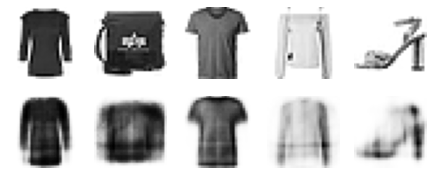

In [86]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [116]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.2846 - rounded_accuracy: 0.9364 - val_loss: 0.2864 - val_rounded_accuracy: 0.9362
Epoch 2/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.2845 - rounded_accuracy: 0.9364 - val_loss: 0.2863 - val_rounded_accuracy: 0.9364
Epoch 3/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.2844 - rounded_accuracy: 0.9365 - val_loss: 0.2862 - val_rounded_accuracy: 0.9363
Epoch 4/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.2843 - rounded_accuracy: 0.9366 - val_loss: 0.2862 - val_rounded_accuracy: 0.9362
Epoch 5/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.2843 - rounded_accuracy: 0.9367 - val_loss: 0.2861 - val_rounded_accuracy: 0.9365
Epoch 6/10
55000/55000 [==============================] - 4s 82us/sample - loss: 0.2842 - rounded_accuracy: 0.9367 - val_loss:

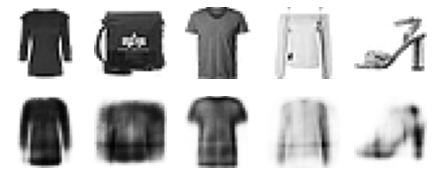

In [89]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

# 합성곱 오토인코더 

In [123]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="selu", input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data = (X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 7s 135us/sample - loss: 0.3011 - rounded_accuracy: 0.9193 - val_loss: 0.2786 - val_rounded_accuracy: 0.9420
Epoch 2/5
55000/55000 [==============================] - 6s 117us/sample - loss: 0.2755 - rounded_accuracy: 0.9415 - val_loss: 0.2748 - val_rounded_accuracy: 0.9446
Epoch 3/5
55000/55000 [==============================] - 7s 118us/sample - loss: 0.2709 - rounded_accuracy: 0.9460 - val_loss: 0.2715 - val_rounded_accuracy: 0.9460
Epoch 4/5
55000/55000 [==============================] - 6s 118us/sample - loss: 0.2684 - rounded_accuracy: 0.9485 - val_loss: 0.2681 - val_rounded_accuracy: 0.9508
Epoch 5/5
55000/55000 [==============================] - 6s 118us/sample - loss: 0.2666 - rounded_accuracy: 0.9504 - val_loss: 0.2663 - val_rounded_accuracy: 0.9529


# 순환 오토인코더 

In [187]:
recurrent_encoder = keras.models.Sequential([
### input_shape=[28, 28]은 28 timestep에 대한 28개의 변화값이다.
### 출력차원이 [..., 28, 100]형태를 띄는건 당연하다
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
###REpeatVector는  ...,30 -> (...,28, 30)형태로 입력을 반복한다
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 30]),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid", input_shape=[28, 100]))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [188]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [189]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data = (X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 17s 315us/sample - loss: 0.4982 - rounded_accuracy: 0.7734 - val_loss: 0.4301 - val_rounded_accuracy: 0.8219
Epoch 2/10
55000/55000 [==============================] - 12s 223us/sample - loss: 0.3947 - rounded_accuracy: 0.8476 - val_loss: 0.3725 - val_rounded_accuracy: 0.8656
Epoch 3/10
55000/55000 [==============================] - 12s 223us/sample - loss: 0.3640 - rounded_accuracy: 0.8709 - val_loss: 0.3620 - val_rounded_accuracy: 0.8741
Epoch 4/10
55000/55000 [==============================] - 12s 222us/sample - loss: 0.3523 - rounded_accuracy: 0.8796 - val_loss: 0.3545 - val_rounded_accuracy: 0.8800
Epoch 5/10
55000/55000 [==============================] - 12s 226us/sample - loss: 0.3428 - rounded_accuracy: 0.8859 - val_loss: 0.3391 - val_rounded_accuracy: 0.8918
Epoch 6/10
55000/55000 [==============================] - 12s 225us/sample - loss: 0.3353 - rounded_accuracy: 0.8911

In [206]:
recurrent_encoder = keras.models.Sequential([
### input_shape=[28, 28]은 28 timestep에 대한 28개의 변화값이다.
### 출력차원이 [..., 28, 100]형태를 띄는건 당연하다
    keras.layers.LSTM(100, return_sequences=True, input_shape=[784, 1]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
###REpeatVector는  ...,30 -> (...,28, 30)형태로 입력을 반복한다
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 30]),
    keras.layers.TimeDistributed(keras.layers.Dense(784, activation="sigmoid", input_shape=[28, 100]))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [207]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [211]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data = (X_temp_2, X_temp_2))

ValueError: Error when checking input: expected sequential_127_input to have shape (784, 1) but got array with shape (28, 28)

In [194]:
X_temp=np.array(X_train).flatten().tolist()

In [198]:
X_temp = np.array(X_temp)

In [199]:
X_temp.shape

(43120000,)

In [204]:
X_temp = X_temp.reshape(55000, 784, 1)

In [205]:
X_temp.shape

(55000, 784, 1)

In [210]:
X_temp_2=np.array(X_valid).flatten().tolist()
X_temp_2 = np.array(X_temp_2)
X_temp_2 = X_temp_2.reshape(5000, 784, 1)

In [212]:
X_temp_2.shape

(5000, 784, 1)